In [ ]:
!pip install contextily

In [ ]:
import pandas as pd
import geopandas as gpd
import os
import zipfile
import contextily as ctx

In [ ]:


FOLDER_PATH = '/content/drive/MyDrive/DSL SMART CITIES'

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import pandas as pd
import numpy as np

In [ ]:
data = gpd.read_file("/content/drive/MyDrive/DSL SMART CITIES/merged_data.csv")

In [ ]:
data.head()

ID_NIL           area_sqkm charging_stations charging_stations_per_sqkm  \
0      1    2.34161556588591              22.0          9.395222819881058   
1     10  1.5560187497830058              15.0          9.639986666029456   
2     11  1.3228871157647772               2.0         1.5118447947418217   
3     12  1.6749176277225284               3.0         1.7911328595181448   
4     13  1.7686026100672578               2.0         1.1308362820543063   

  n_schools_x school_bus_accessibility urban_transport_accessibility  \
0          10                      3.0                           7.0   
1           2                      0.0                           2.0   
2           7                      3.0                           3.0   
3           9                      1.0                           6.0   
4           5                      0.0                           4.0   

  interurban_transport_accessibility rail_transport_accessibility  \
0                                3.0                          3.0   
1                                2.0                          2.0   
2                                0.0                          2.0   
3                                4.0                          1.0   
4                                1.0                          0.0   

  private_transport_accessibility  ... private_schools public_schools  \
0                             7.0  ...             3.0            1.0   
1                             2.0  ...             2.0            3.0   
2                             6.0  ...             1.0            1.0   
3                             6.0  ...             3.0            0.0   
4                             3.0  ...             2.0            0.0   

  private_schools_per_sqkm public_schools_per_sqkm public_toilets  \
0       1.2811667481655988      0.4270555827218663             18   
1       1.2853315554705942       1.927997333205891             12   
2       0.7559223973709108      0.7559223973709108              2   
3       1.7911328595181448                     0.0              3   
4       1.1308362820543063                     0.0              2   

  public_toilets_per_sqkm bike_slots bike_slots_per_sqkm            roads_km  \
0       7.687000488993593         79   33.73739103502744   39.58761873480128   
1       7.711989332823564         10    6.42665777735297   31.25757683255042   
2      1.5118447947418217          3  2.2677671921127325   25.82631624413059   
3      1.7911328595181448          1  0.5970442865060483   36.40602842173778   
4      1.1308362820543063          2  1.1308362820543063  19.614378862669238   

          walkways_km  
0  16.259896874947493  
1   1.052163777748754  
2    1.08564988783689  
3  0.3331261914981306  
4  0.9145802205975534  

[5 rows x 54 columns]

In [ ]:
data.columns

Index(['ID_NIL', 'area_sqkm', 'charging_stations',
       'charging_stations_per_sqkm', 'n_schools_x', 'school_bus_accessibility',
       'urban_transport_accessibility', 'interurban_transport_accessibility',
       'rail_transport_accessibility', 'private_transport_accessibility',
       'disable_transport_accessability', 'n_sport_centers', 'n_schools_y',
       'ordinary_hospitalization', 'payment_hospitalization', 'day_hospital',
       'day_surgery', 'total_beds', 'remediable_buildings',
       'green_spaces_sqkm', 'green_spaces_ratio', 'green_space_per_person',
       'bike_lane_km', 'parking_sqkm', 'count_underground', 'count_surface',
       'underground_stops_per_resident', 'surface_stops_per_resident',
       'underground_stops_per_sqkm', 'surface_stops_per_sqkm', 'geometry',
       '0-2 anni', '11-13 anni', '14-18 anni', '19-24 anni', '25-34 anni',
       '3-5 anni', '35-44 anni', '45-54 anni', '55-64 anni', '6-10 anni',
       '65-74 anni', '75-84 anni', '85 anni e più', 'pr

In [ ]:
# Conversione delle colonne necessarie in formato numerico
columns_to_convert = [
    'urban_transport_accessibility',
    'green_space_per_person',
    'charging_stations',
    'charging_stations_per_sqkm',
    'bike_slots',
    'bike_slots_per_sqkm',
    'green_spaces_ratio',
    'green_spaces_sqkm',
    'interurban_transport_accessibility',
    'rail_transport_accessibility',
    'private_transport_accessibility',
    'public_toilets',
    'bike_slots',
    'area_sqkm',
    'n_schools_x',
    'charging_stations',
    '0-2 anni',
    '3-5 anni',
    '6-10 anni',
    '11-13 anni',
    '14-18 anni',
    '65-74 anni',
    '75-84 anni',
    '85 anni e più'
]

for col in columns_to_convert:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [ ]:
# Calcolo degli indici
# Indice di accessibilità ai trasporti
data['transport_accessibility_index'] = data[[
    'urban_transport_accessibility',
    'interurban_transport_accessibility',
    'rail_transport_accessibility',
    'private_transport_accessibility'
]].mean(axis=1)

# Indice di infrastrutture pubbliche
data['public_infrastructure_index'] = np.where(
    data['area_sqkm'] > 0,
    (data['public_toilets'] + data['bike_slots']) / data['area_sqkm'],
    np.nan
)

# Indice di densità di servizi scolastici
data['school_density_index'] = np.where(
    data['area_sqkm'] > 0,
    data['n_schools_x'] / data['area_sqkm'],
    np.nan
)

# Indice di scuole per under18
data['schools_per_under18'] = np.where(
    data[['6-10 anni' ,'11-13 anni', '14-18 anni']].sum(axis=1) > 500,
    (data['n_schools_x']) / (data[['6-10 anni' ,'11-13 anni', '14-18 anni']].sum(axis=1)),
    0
)

# Indice di sostenibilità
data['sustainability_index'] = np.where(
    data['area_sqkm'] > 0,
    (data['charging_stations'] + data['bike_slots']) / data['area_sqkm'],
    np.nan
)


# Indice di popolazione vulnerabile: somma di % Under 14 (0-18 anni) e % Over 65 (65 anni e più)
data['vulnerable_population_index'] = (
    data[['0-2 anni', '11-13 anni', '14-18 anni']].sum(axis=1) +
    data[['65-74 anni', '75-84 anni', '85 anni e più']].sum(axis=1)
) / 2

In [ ]:
def calculate_sustainability_index(df, max_values, weights):
    """
    Calculate the Sustainability Index for each row in the DataFrame.

    Parameters:
    - df: DataFrame with columns ['green_area', 'bike_stalls', 'charging_stations']
    - max_values: Dictionary with maximum values for normalization
                  e.g., {'green_area': 100, 'bike_stalls': 5000, 'charging_stations': 1000}
    - weights: Dictionary with weights for each component
               e.g., {'green_area': 0.5, 'bike_stalls': 0.3, 'charging_stations': 0.2}

    Returns:
    - A DataFrame with an additional 'sustainability_index' column.
    """
    # Normalize the values for each column
    for col in max_values:
        df[f'norm_{col}'] = df[col] / max_values[col]

    # Normalize weights to ensure they sum to 1
    total_weight = sum(weights.values())
    norm_weights = {k: v / total_weight for k, v in weights.items()}

    # Calculate the Sustainability Index
    df['sustainability_index2'] = (
        df['green_spaces_ratio'] * norm_weights['green_spaces_ratio'] +
        df['charging_stations'] * norm_weights['charging_stations'] +
        df['charging_stations'] * norm_weights['charging_stations']
    )

    return df

max_values = {'green_spaces_ratio': data['green_spaces_ratio'].max(), 'charging_stations': data['charging_stations'].max(), 'charging_stations': data['charging_stations'].max()}

# Weights for each component
weights = {'green_spaces_ratio': 0.333, 'charging_stations': 0.333, 'charging_stations': 0.333}

df = calculate_sustainability_index(data, max_values, weights)

# After calculating the index, apply min-max normalization
min_value = df['sustainability_index2'].min()
max_value = df['sustainability_index2'].max()

# Normalize the index to be in the 0-1 range
df['sustainability_index2'] = (df['sustainability_index2'] - min_value) / (max_value - min_value)

In [ ]:
# Visualizzazione delle prime righe degli indici calcolati
print(data[['transport_accessibility_index', 'public_infrastructure_index',
            'school_density_index', 'schools_per_under18' ,'sustainability_index', 'sustainability_index2',
            'vulnerable_population_index']].head())

   transport_accessibility_index  public_infrastructure_index  \
0                           5.00                    41.424392   
1                           2.00                    14.138647   
2                           2.75                     3.779612   
3                           4.25                     2.388177   
4                           2.00                     2.261673   

   school_density_index  schools_per_under18  sustainability_index  \
0              4.270556             0.004808             43.132614   
1              1.285332             0.001172             16.066644   
2              5.291457             0.003166              3.779612   
3              5.373399             0.003377              2.388177   
4              2.827091             0.002822              2.261673   

   sustainability_index2  vulnerable_population_index  
0               1.000000                       2678.0  
1               0.681176                       2562.0  
2               0.09

In [ ]:
print(data['schools_per_under18'].max())
print(data['schools_per_under18'].min())

0.02181818181818182
0.0


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Creazione di un GeoDataFrame a partire dal dataset
gdf = gpd.GeoDataFrame(data, geometry=gpd.GeoSeries.from_wkt(data['geometry']))

# Funzione per plottare una mappa tematica
def plot_thematic_map(gdf, column, title, cmap='viridis'):
    fig, ax = plt.subplots(figsize=(10, 8))
    gdf.plot(column=column, cmap=cmap, legend=True, ax=ax, edgecolor='black', linewidth=0.5)
    ax.set_title(title, fontsize=16)
    ax.axis('off')
    plt.show()

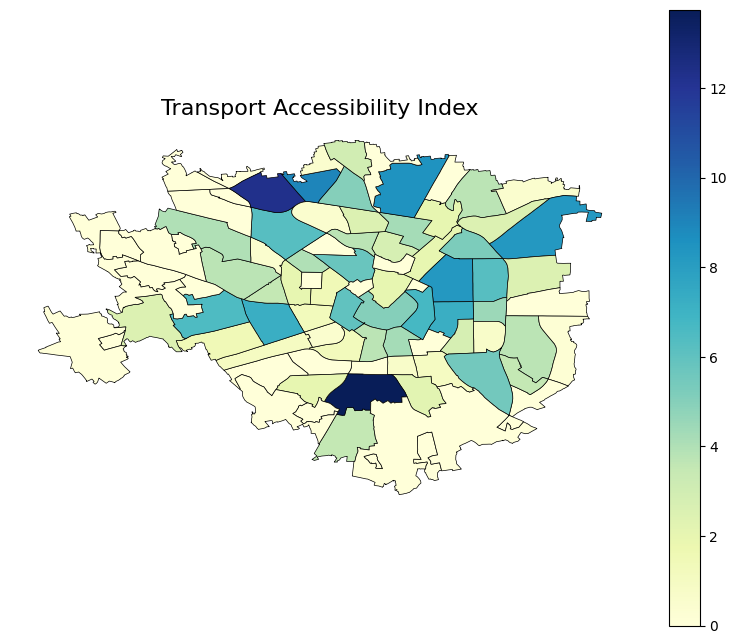

In [ ]:
# Esempi di mappe tematiche per i tuoi indici
plot_thematic_map(gdf, 'transport_accessibility_index', 'Transport Accessibility Index', cmap='YlGnBu')

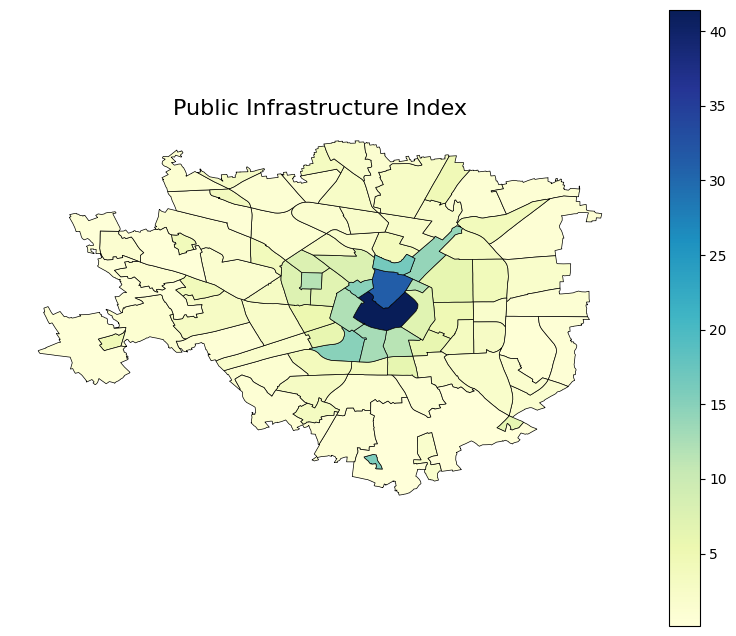

In [ ]:
plot_thematic_map(gdf, 'public_infrastructure_index', 'Public Infrastructure Index', cmap='YlGnBu')

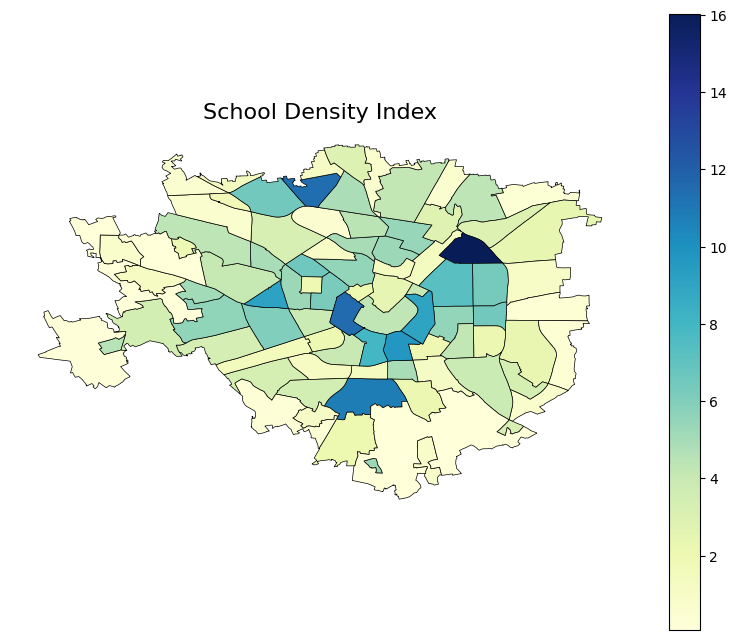

In [ ]:
plot_thematic_map(gdf, 'school_density_index', 'School Density Index', cmap='YlGnBu')

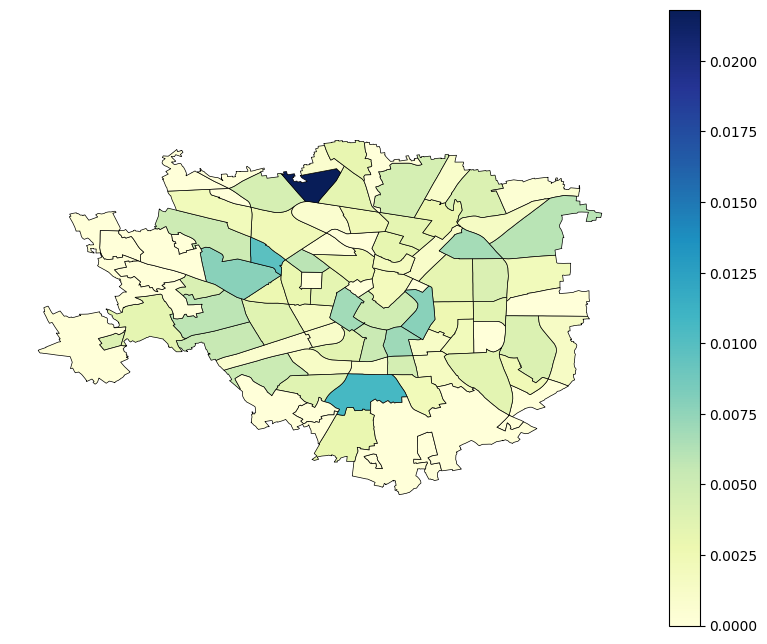

In [ ]:
plot_thematic_map(gdf, 'schools_per_under18', '', cmap='YlGnBu')

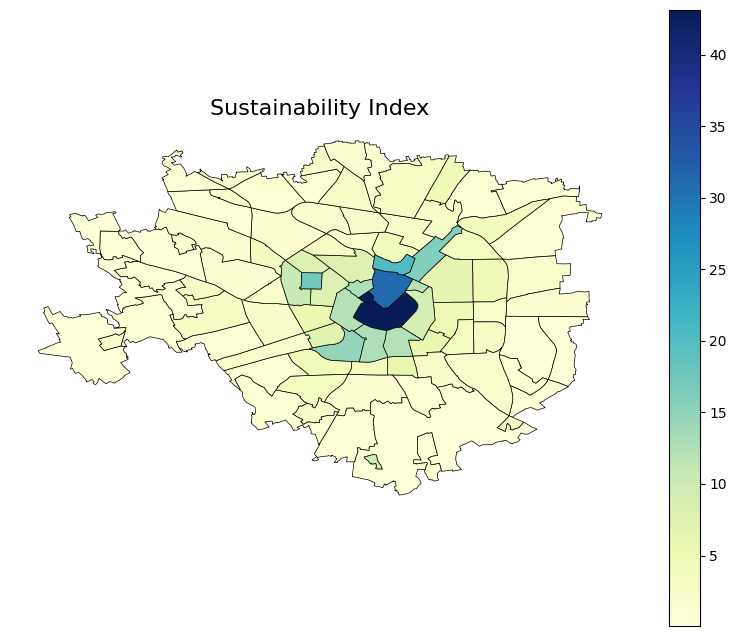

In [ ]:
plot_thematic_map(gdf, 'sustainability_index', 'Sustainability Index', cmap='YlGnBu')

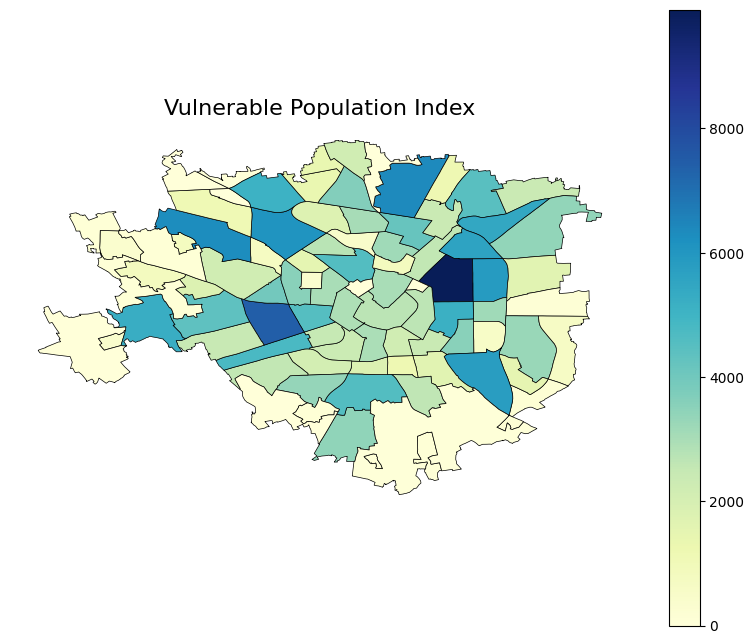

In [ ]:
plot_thematic_map(gdf, 'vulnerable_population_index', 'Vulnerable Population Index', cmap='YlGnBu')

In [ ]:
# Creazione di un GeoDataFrame dal tuo dataset
gdf = gpd.GeoDataFrame(data, geometry=gpd.GeoSeries.from_wkt(data['geometry']), crs="EPSG:4326")

# Verifica delle geometrie
if not gdf.is_valid.all():
    gdf = gdf.buffer(0)  # Correggi eventuali geometrie non valide

# Conversione del sistema di coordinate in Web Mercator (EPSG:3857)
gdf = gdf.to_crs(epsg=3857)

In [ ]:
# Funzione per plottare una mappa tematica con zoom out e mappa opaca
def plot_thematic_map_with_zoom_out(gdf, column, title, cmap='viridis', alpha_data=0.6, background_alpha=0.5, zoom_out_factor=0.1):
    fig, ax = plt.subplots(figsize=(12, 10))

    # Disegnare i dati geospaziali con trasparenza regolata
    gdf.plot(column=column, cmap=cmap, legend=True,
             legend_kwds={'shrink': 0.5}, ax=ax, alpha=alpha_data, edgecolor='black', linewidth=0.7)

    # Calcolo dei nuovi limiti con zoom out
    x_min, y_min, x_max, y_max = gdf.total_bounds
    x_range = x_max - x_min
    y_range = y_max - y_min
    ax.set_xlim(x_min - zoom_out_factor * x_range, x_max + zoom_out_factor * x_range)
    ax.set_ylim(y_min - zoom_out_factor * y_range, y_max + zoom_out_factor * y_range)

    # Aggiungi la mappa di base con maggiore opacità
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12, alpha=background_alpha)

    ax.set_title(title, fontsize=16)
    ax.axis('off')
    plt.show()

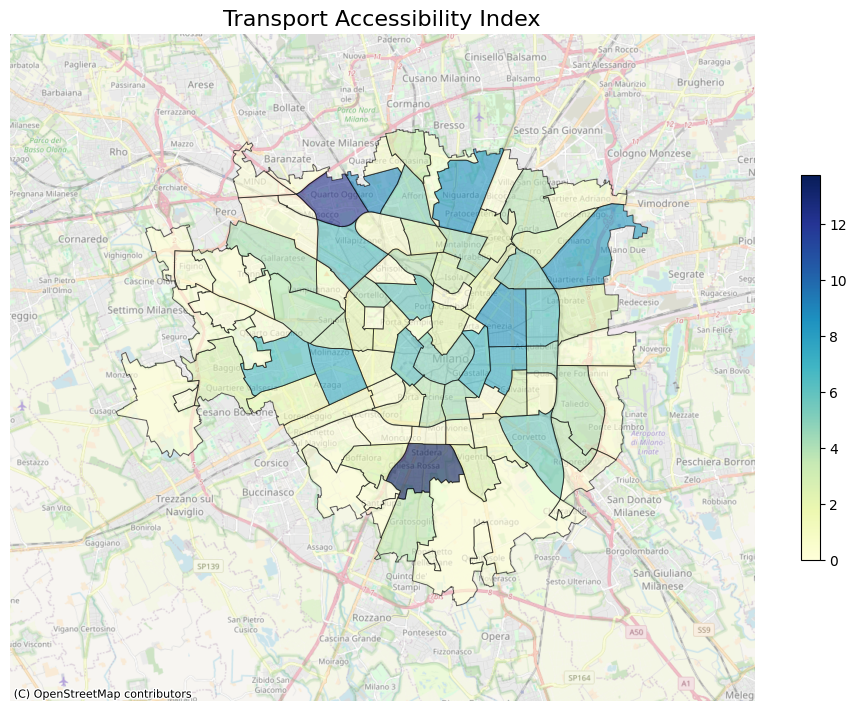

In [ ]:
plot_thematic_map_with_zoom_out(gdf, 'transport_accessibility_index', 'Transport Accessibility Index', cmap='YlGnBu', alpha_data=0.6, background_alpha=0.6, zoom_out_factor=0.2)


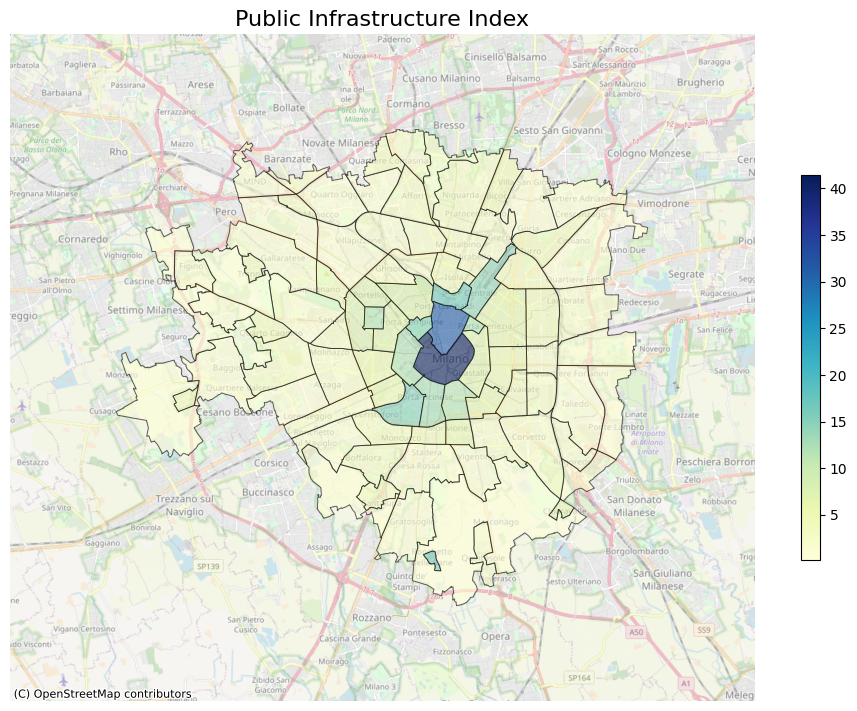

In [ ]:
plot_thematic_map_with_zoom_out(gdf, 'public_infrastructure_index', 'Public Infrastructure Index', cmap='YlGnBu', alpha_data=0.6, background_alpha=0.6, zoom_out_factor=0.2)


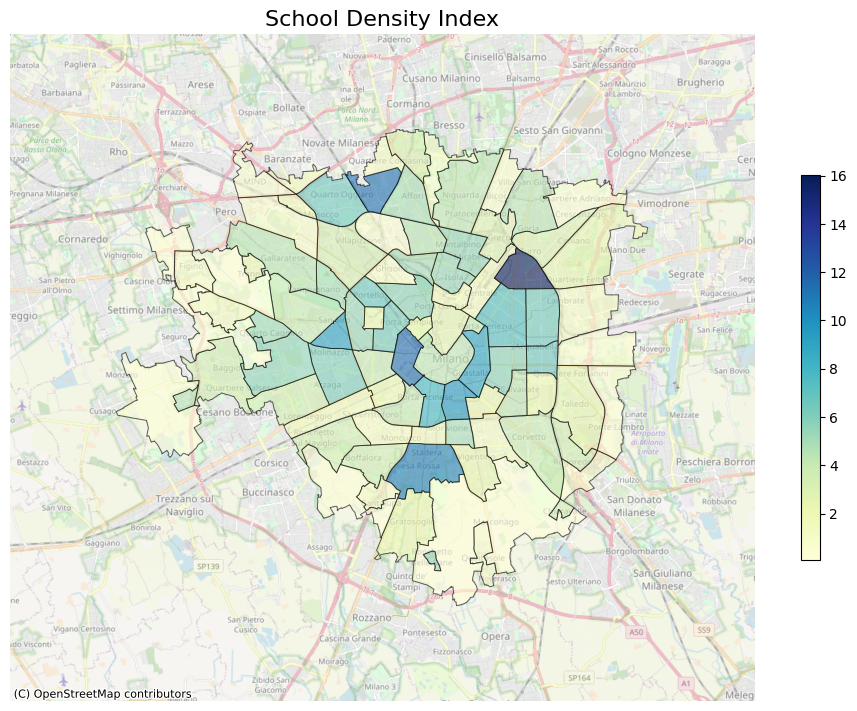

In [ ]:
plot_thematic_map_with_zoom_out(gdf, 'school_density_index', 'School Density Index', cmap='YlGnBu', alpha_data=0.6, background_alpha=0.6, zoom_out_factor=0.2)


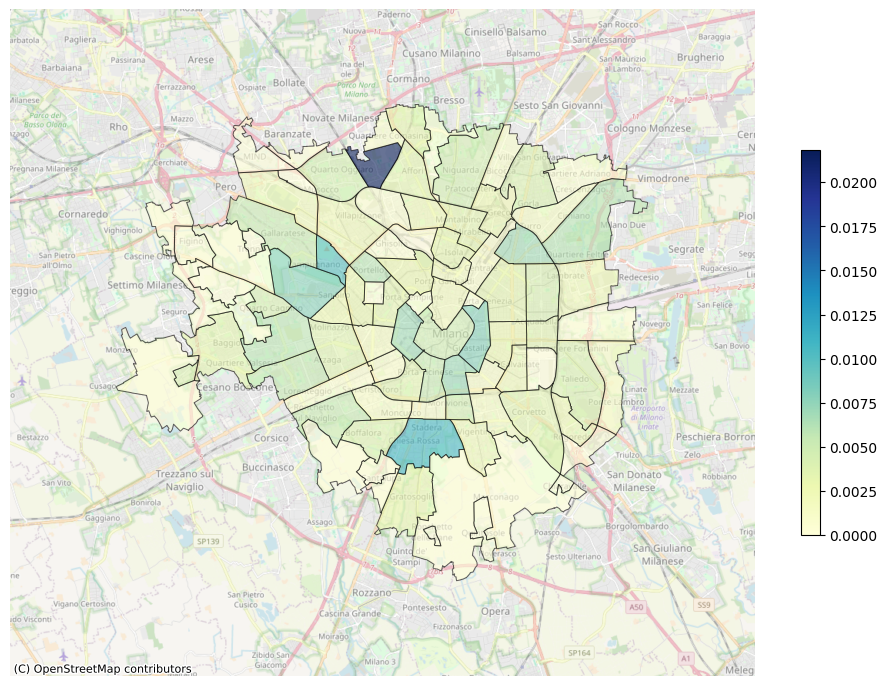

In [ ]:
plot_thematic_map_with_zoom_out(gdf, 'schools_per_under18', '', cmap='YlGnBu', alpha_data=0.6, background_alpha=0.6, zoom_out_factor=0.2)


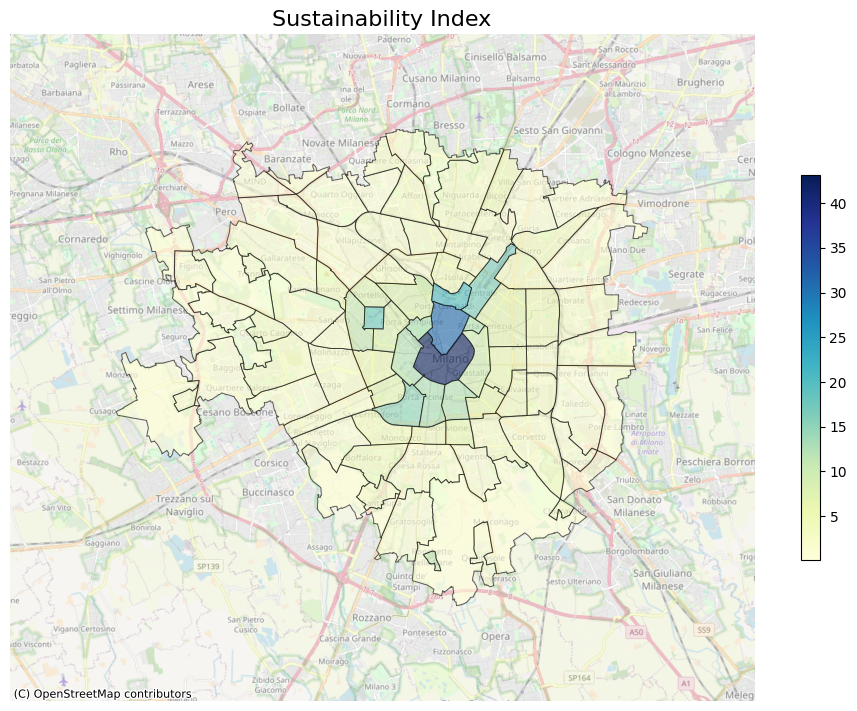

In [ ]:
plot_thematic_map_with_zoom_out(gdf, 'sustainability_index', 'Sustainability Index', cmap='YlGnBu', alpha_data=0.6, background_alpha=0.6, zoom_out_factor=0.2)


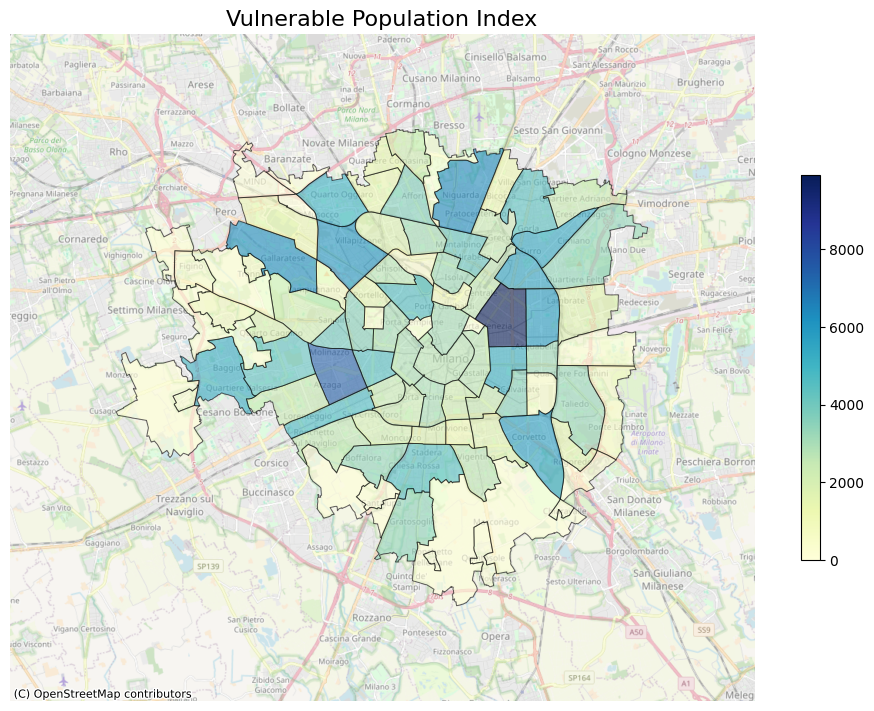

In [ ]:
plot_thematic_map_with_zoom_out(gdf, 'vulnerable_population_index', 'Vulnerable Population Index', cmap='YlGnBu', alpha_data=0.6, background_alpha=0.6, zoom_out_factor=0.2)

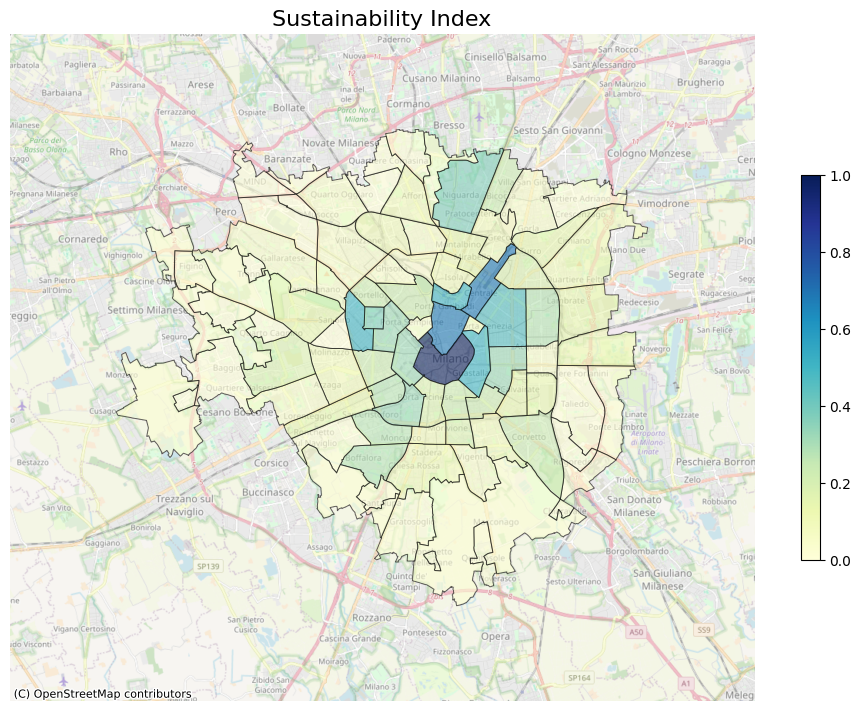

In [ ]:
plot_thematic_map_with_zoom_out(gdf, 'sustainability_index2', 'Sustainability Index', cmap='YlGnBu', alpha_data=0.6, background_alpha=0.6, zoom_out_factor=0.2)